In [1]:
import croissant as cro
import croissant.jax as crojax
from functools import partial
from healpy import get_nside, projview
import jax
import jax.numpy as jnp
import lunarsky
import matplotlib.pyplot as plt
import s2fft

In [2]:
# simulation parameters
world = "moon"
L = 180  # maximal harmonic band limit given sampling of beam
freq = jnp.arange(1, 51)  # 1-50 MHz
time = lunarsky.Time("2025-12-01 09:00:00")  # time at the beginning of the simulation
loc = lunarsky.MoonLocation(lon=0, lat=-22.5)  # location of telescope
topo = lunarsky.LunarTopo(obstime=time, location=loc) # coordinate frame of telescope
# 240 bins in a sidereal day on the moon
ntimes = 240
dt = cro.constants.sidereal_day[world] / ntimes
phases = crojax.simulator.rot_alm_z(L-1, ntimes, dt, world=world)

# get the euler angles and wigner d functions for the coordinate transforms
eul_topo, dl_topo = crojax.rotations.generate_euler_dl(L-1, topo, "mcmf")  # beam transform, from topocentric to mcmf
eul_gal, dl_gal = crojax.rotations.generate_euler_dl(L-1, "galactic", "mcmf")  # sky transform, from galactic to mcmf

topo2mcmf = partial(s2fft.utils.rotation.rotate_flms, L=L, rotation=eul_topo, dl_array=dl_topo)
gal2mcmf = partial(s2fft.utils.rotation.rotate_flms, L=L, rotation=eul_gal, dl_array=dl_gal)

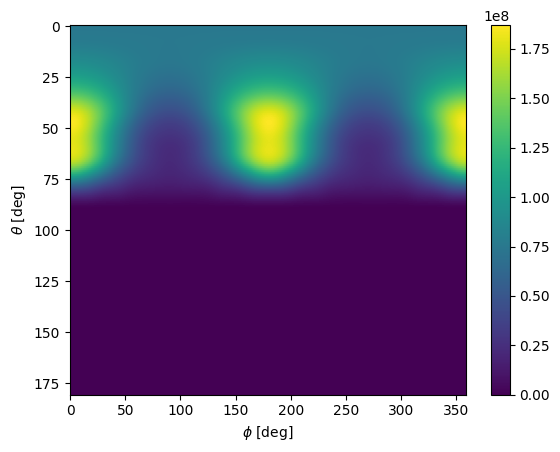

In [3]:
etheta, ephi = jnp.load("lusee_beam.npy")[:, :, :, :-1]
beam = jnp.abs(etheta)**2 + jnp.abs(ephi)**2  # power beam
# add horizon
beam = jnp.concatenate((beam, jnp.zeros_like(beam)[:, :-1, :]), axis=1)
plt.figure()
plt.imshow(beam[30], aspect="auto")
plt.xlabel("$\\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.colorbar()
plt.show()

In [15]:
# define the map2alm transform for the beam
beam2alm = partial(s2fft.forward_jax, L=L, spin=0, nside=None, sampling="mwss", reality=True)
# use vmap t vectorize frequency axis
beam_alm = jax.vmap(beam2alm)(beam)

# normalization for visibilities
norm = crojax.alm.total_power(beam_alm, L-1)

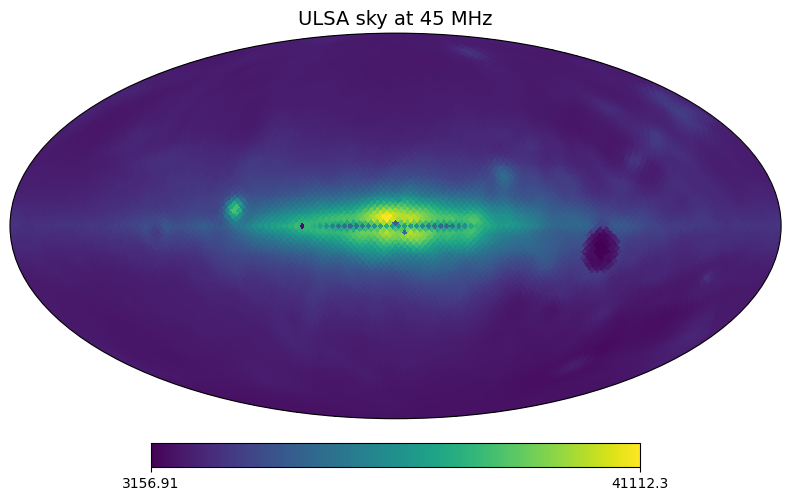

In [5]:
# sky
sky_map = jnp.load("ulsa.npy")
ix = -6
projview(m=sky_map[ix], title=f"ULSA sky at {freq[ix]} MHz")
plt.show()

In [6]:
# define the map2alm transform for the sky
sky2alm = partial(s2fft.forward_jax, L=L, spin=0, nside=get_nside(sky_map[0]), sampling="healpix", reality=True)
sky_alm = jax.vmap(sky2alm)(sky_map)

In [7]:
# coordinate transform
beam_alm = jax.vmap(topo2mcmf)(beam_alm)
sky_alm = jax.vmap(gal2mcmf)(sky_alm)

In [16]:
vis = crojax.simulator.convolve(beam_alm, sky_alm, phases).real / norm

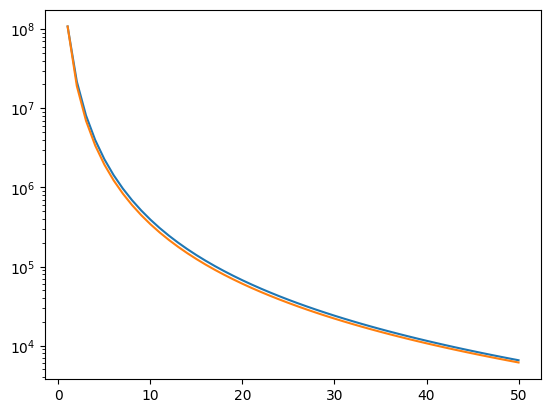

In [17]:
plt.figure()
plt.plot(freq, jnp.mean(sky_map, axis=-1))
plt.plot(freq, jnp.mean(sky_map, axis=-1)[0] * (freq/freq.min())**(-2.5))
plt.yscale("log")
plt.show()

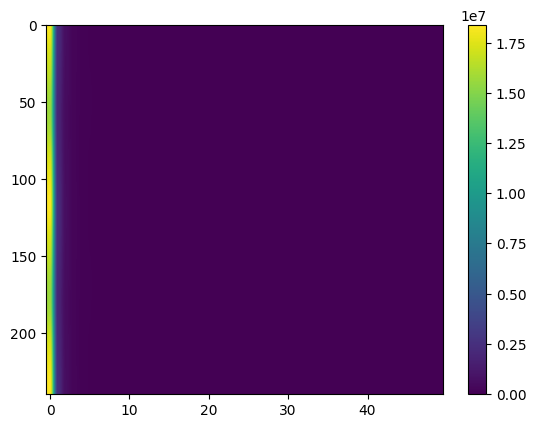

In [20]:
plt.figure()
plt.imshow(vis, aspect="auto")
plt.colorbar()
plt.show()

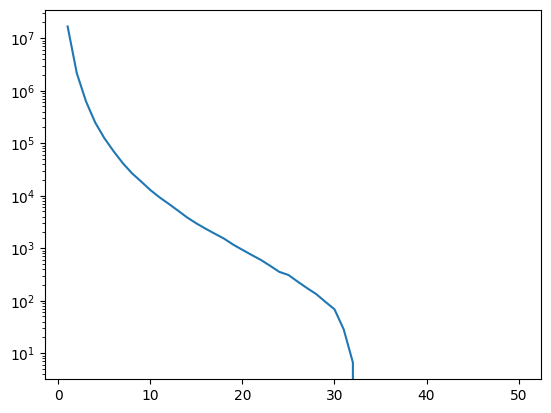

In [23]:
plt.figure()
plt.plot(freq, vis[150])
plt.yscale("log")
plt.show()